# Predict a Powerlifter's Best Deadlift (by Andrew Dettor)

### Dataset: [Powerlifting Database](https://www.kaggle.com/open-powerlifting/powerlifting-database)
### Goals:
* Deal with missing values present in dataset
* Explore distributions of features and their relationships with the target feature, Best3DeadliftKg (best deadlift from 3 attempts)
* Preprocess data in order to model it (look at outliers/skewed distributions/standardization)
* Test out different Regression models and compare their performance
* Tune hyperparameters of the best model
* Explore which features were the most impactful
* Explore interactions between features


### FYI - Confusing Names for Features:
* Squat3Kg - Lifter's 3rd squat attempt weight. Negative means the attempt was failed. "Ignore NaN" according to the dataset creator, which doesn't make sense to me. How do I just 'ignore' NaN?
* Bench1Kg - Lifter's 1st bench attempt weight.
* Best3BenchKg - Lifter's highest weight benched out of 3 attempts.
* Wilks/McCulloch/Glossbrenner/IPFPoints - Metrics used to measure a lifter's performance against others. Takes into account bodyweight and powerlifting total (which is equal to Best3BenchKg + Best3SquatKg + Best3DeadliftKg) among other things.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/powerlifting-database/openpowerlifting.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

# *Read in the Data*

In [3]:
fname = "../input/powerlifting-database/openpowerlifting.csv"
df = pd.read_csv(fname, parse_dates=True)
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date,MeetCountry,MeetState,MeetName
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.8,60,80.0,...,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
1,Abbie Tuong,F,SBD,Wraps,29.0,24-34,F-OR,58.5,60,100.0,...,378.07,334.16,595.65,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
2,Ainslee Hooper,F,B,Raw,40.0,40-44,F-OR,55.4,56,NaN,...,38.56,34.12,313.97,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
3,Amy Moldenhauer,F,SBD,Wraps,23.0,20-23,F-OR,60.0,60,-105.0,...,345.61,305.37,547.04,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup
4,Andrea Rowan,F,SBD,Wraps,45.0,45-49,F-OR,104.0,110,120.0,...,338.91,274.56,550.08,NaN,NaN,GPC-AUS,2018-10-27,Australia,VIC,Melbourne Cup


In [4]:
df.shape

(1423354, 37)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1423354 entries, 0 to 1423353
Data columns (total 37 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Name             1423354 non-null  object 
 1   Sex              1423354 non-null  object 
 2   Event            1423354 non-null  object 
 3   Equipment        1423354 non-null  object 
 4   Age              757527 non-null   float64
 5   AgeClass         786800 non-null   object 
 6   Division         1415176 non-null  object 
 7   BodyweightKg     1406622 non-null  float64
 8   WeightClassKg    1410042 non-null  object 
 9   Squat1Kg         337580 non-null   float64
 10  Squat2Kg         333349 non-null   float64
 11  Squat3Kg         323842 non-null   float64
 12  Squat4Kg         3696 non-null     float64
 13  Best3SquatKg     1031450 non-null  float64
 14  Bench1Kg         499779 non-null   float64
 15  Bench2Kg         493486 non-null   float64
 16  Bench3Kg         4

In [6]:
df.describe()

,Age,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,...,Deadlift1Kg,Deadlift2Kg,Deadlift3Kg,Deadlift4Kg,Best3DeadliftKg,TotalKg,Wilks,McCulloch,Glossbrenner,IPFPoints
count,757527.000000,1.406622e+06,337580.000000,333349.000000,323842.000000,3696.000000,1.031450e+06,499779.000000,493486.000000,478485.000000,...,363544.000000,356023.000000,339947.000000,9246.000000,1.081808e+06,1.313184e+06,1.304407e+06,1.304254e+06,1.304407e+06,1.273286e+06
mean,31.501570,8.422503e+01,114.102442,92.155846,30.056842,71.356870,1.740049e+02,83.892373,55.065745,-18.520481,...,162.700840,130.228378,12.995484,78.914945,1.872585e+02,3.956148e+02,2.882247e+02,2.960682e+02,2.718484e+02,4.854330e+02
std,13.371707,2.322011e+01,147.143021,173.701524,200.413385,194.522045,6.923931e+01,105.196350,130.302229,144.225726,...,108.681438,162.680134,215.052488,192.605159,6.232821e+01,2.011420e+02,1.231805e+02,1.249700e+02,1.175571e+02,1.133489e+02
min,0.000000,1.510000e+01,-555.000000,-580.000000,-600.500000,-550.000000,-4.775000e+02,-480.000000,-507.500000,-575.000000,...,-461.000000,-470.000000,-587.500000,-461.000000,-4.100000e+02,2.500000e+00,1.470000e+00,1.470000e+00,1.410000e+00,2.160000e+00
25%,21.000000,6.670000e+01,90.000000,68.000000,-167.500000,-107.840000,1.224700e+02,57.500000,-52.500000,-140.000000,...,125.000000,115.000000,-210.000000,-110.000000,1.383500e+02,2.325000e+02,1.979000e+02,2.048200e+02,1.828100e+02,4.028600e+02
50%,28.000000,8.180000e+01,147.500000,145.000000,110.000000,135.000000,1.678300e+02,105.000000,95.000000,-60.000000,...,180.000000,177.500000,117.500000,145.150000,1.850000e+02,3.787500e+02,3.052000e+02,3.120300e+02,2.859400e+02,4.780500e+02
75%,40.000000,9.915000e+01,200.000000,205.000000,192.500000,205.000000,2.175000e+02,145.000000,145.000000,117.500000,...,226.800000,230.000000,205.000000,210.000000,2.300000e+02,5.400000e+02,3.745600e+02,3.837600e+02,3.552800e+02,5.597000e+02
max,97.000000,2.580000e+02,555.000000,566.990000,560.000000,505.500000,5.750000e+02,467.500000,487.500000,478.540000,...,450.000000,460.400000,457.500000,418.000000,5.850000e+02,1.367500e+03,7.793800e+02,8.044000e+02,7.429600e+02,1.245930e+03


# *Data Cleaning*

In [7]:
# What percent of each feature is missing?

lst = []
for cname in df.columns.tolist():
    percentage = round((100*df[cname].isna().sum()/df[cname].isna().count()), 2)
    lst.append((cname, percentage))

lst.sort(reverse=True, key = lambda x: x[1])

for element in lst:
    print(element[0] + ": " + str(element[1]) + "%")

Squat4Kg: 99.74%
Deadlift4Kg: 99.35%
Bench4Kg: 99.33%
Squat3Kg: 77.25%
Squat2Kg: 76.58%
Squat1Kg: 76.28%
Deadlift3Kg: 76.12%
Deadlift2Kg: 74.99%
Deadlift1Kg: 74.46%
Country: 72.68%
Bench3Kg: 66.38%
Bench2Kg: 65.33%
Bench1Kg: 64.89%
Age: 46.78%
AgeClass: 44.72%
MeetState: 33.85%
Best3SquatKg: 27.53%
Best3DeadliftKg: 24.0%
Tested: 23.15%
IPFPoints: 10.54%
Best3BenchKg: 10.34%
McCulloch: 8.37%
Wilks: 8.36%
Glossbrenner: 8.36%
TotalKg: 7.74%
BodyweightKg: 1.18%
WeightClassKg: 0.94%
Division: 0.57%
Name: 0.0%
Sex: 0.0%
Event: 0.0%
Equipment: 0.0%
Place: 0.0%
Federation: 0.0%
Date: 0.0%
MeetCountry: 0.0%
MeetName: 0.0%


In [8]:
# Removing Deadlift1Kg, Deadlift2Kg, Deadlift3Kg, TotalKg and Place because target leakage

df = df.drop(["Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg", "TotalKg", "Place"], axis=1)

In [9]:
# Removing the lifter metrics because they use Total in their calculation

df = df.drop(["Wilks", "Glossbrenner", "IPFPoints", "McCulloch"], axis=1)

In [10]:
# Remove Squat4Kg, Deadlift4Kg, and Bench4Kg because they're rarely used

df = df.drop(["Squat4Kg", "Deadlift4Kg", "Bench4Kg"], axis=1)

In [11]:
# Remove AgeClass and WeightClass because they can be substituted by Age and BodyWeightKg

df = df.drop(["AgeClass", "WeightClassKg"], axis=1)

In [12]:
# Remove MeetName because I don't want it to affect predictions
# Remove Event because it'll all be SBD anyways

df = df.drop(["MeetName", "Event"], axis=1)

In [13]:
# Target is Best3DeadliftKg, so remove any rows where it is NaN or negative
# Do the same for these other rows
# I can be choosy when dropping rows with NaNs because there's so much data

removeNANCols = ["BodyweightKg", "Age", "Best3DeadliftKg", "Best3SquatKg", "Best3BenchKg"]

for col in removeNANCols:
    df = df.loc[(df[col].isna() == False) & (df[col] > 0)]

In [14]:
# Drop Name, even though there are name repeats
# I'm going to consider each meet entrant a new person
# Yes, this will skew results towards those who were in many meets, but I hope it works out fine

print(df["Name"].value_counts())

df = df.drop("Name", axis=1)

Jackie Blasbery      139
Karel Ruso           134
Libor Novák          107
Erik Rasmussen       102
John Myers            90
                    ... 
Sergiy Zavodskyy       1
Emily Geries           1
Inkvar Axelsson        1
Nicholas Gabriel       1
Bradley Magnusson      1
Name: Name, Length: 150773, dtype: int64


In [15]:
# Make the values in these columns easier to work with
# Removes NaNs in the process
# Categorizing these columns removes the possible target leakage from the deadlift columns
# Creates a separate feature for if the lift attempt was failed/successful/unknown outcome

attemptCols = ["Squat1Kg", "Squat2Kg", "Squat3Kg", "Bench1Kg", "Bench2Kg", "Bench3Kg"]

import math

def attemptTransformer(datapoint):
    if math.isnan(datapoint):
        return "Unknown"
    elif datapoint <= 0:
        return "Fail"
    else:
        return "Success"
    
for col in attemptCols:
    df[col] = df[col].apply(lambda x: attemptTransformer(x))

In [16]:
# Replace NaN with No

df["Tested"] = df["Tested"].fillna("No")

In [17]:
# Use simple imputer to impute these categorical features
from sklearn.impute import SimpleImputer

simpImputeCols = ["Country", "MeetState", "Division"]

simpImputer = SimpleImputer(strategy="constant")
df[simpImputeCols] = simpImputer.fit_transform(df[simpImputeCols])

In [18]:
# Check if there are any NaNs left

df.isna().any()

Sex                False
Equipment          False
Age                False
Division           False
BodyweightKg       False
Squat1Kg           False
Squat2Kg           False
Squat3Kg           False
Best3SquatKg       False
Bench1Kg           False
Bench2Kg           False
Bench3Kg           False
Best3BenchKg       False
Best3DeadliftKg    False
Tested             False
Country            False
Federation         False
Date               False
MeetCountry        False
MeetState          False
dtype: bool

In [19]:
# See how many training examples and columns we're left with

df.shape

(468843, 20)

In [20]:
# Reindex

df.index = np.arange(df.shape[0])

In [21]:
# Get X and y

X = df.drop("Best3DeadliftKg", axis=1)
y = df["Best3DeadliftKg"]

In [22]:
# Make lists of the numerical and categorical columns
categorical = [cname for cname in X.columns.tolist() if X[cname].dtype == "object"]
numerical = [cname for cname in X.columns.tolist() if X[cname].dtype == "float64"]

# *Exploratory Data Analysis*

## Numerical Features

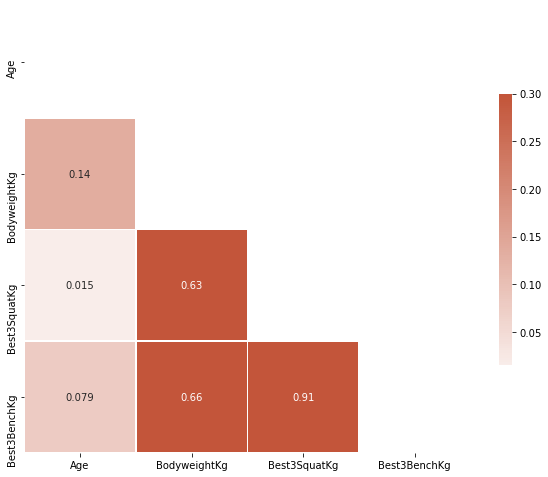

In [23]:
# Create a correlation heatmap between the numerical values
# Source: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Compute the correlation matrix
corr = X[numerical].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Very high correlation between best squat and deadlitft.  Bodyweight has some correlation with best squat and deadlift.

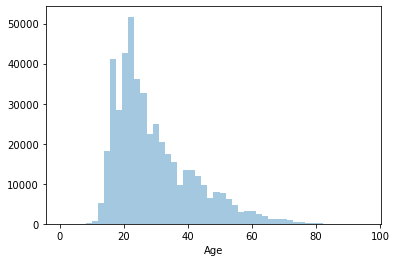

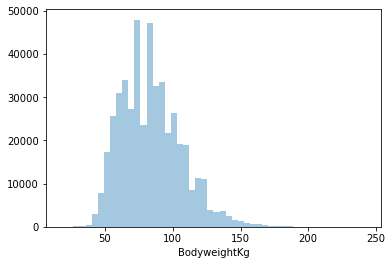

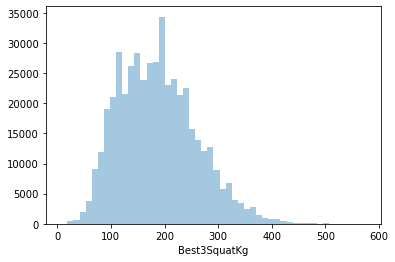

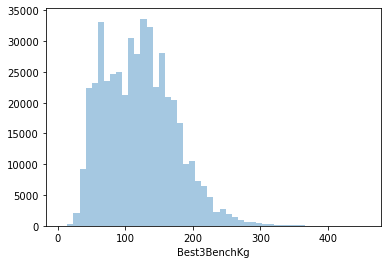

In [24]:
# Create histograms for each numerical feature to see their distributions

for cname in numerical:
    sns.distplot(a=X[cname], kde=False)
    plt.show()

There were so many missing values for these features that the imputed values stick out like a sore thumb. I don't know if there was much I could do about that.

Most of these numerical features look normally distributed. Maybe a little right skew.

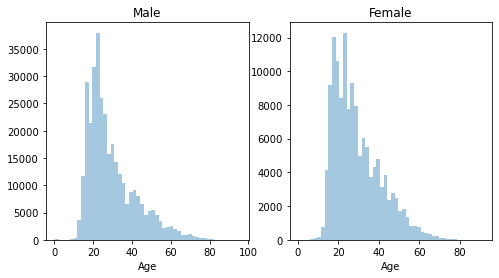

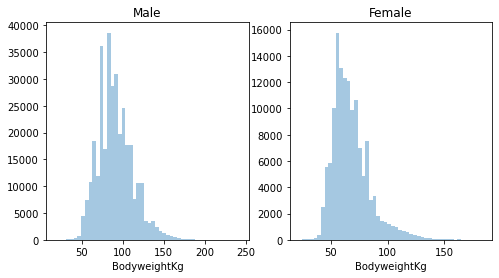

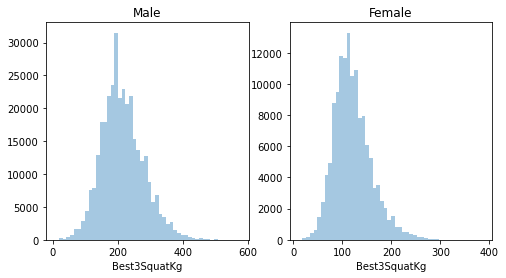

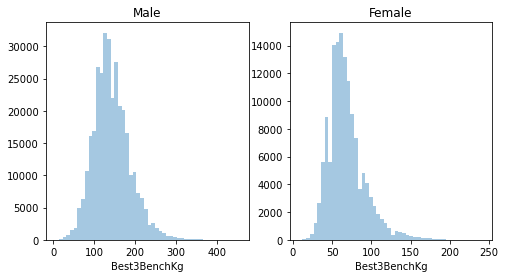

In [25]:
# See distributions based on Sex
for cname in numerical:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    male_cname = X.loc[X["Sex"] == "M"].index
    female_cname = X.loc[X["Sex"] == "F"].index
    
    sns.distplot(a=X[cname].iloc[male_cname], kde=False, ax=ax1)
    ax1.title.set_text('Male')
    sns.distplot(a=X[cname].iloc[female_cname], kde=False, ax=ax2)
    ax2.title.set_text('Female')
    
    plt.show()

Distributions didn't seem to change much, except that the male Kgs on everything are shifted up by a lot.

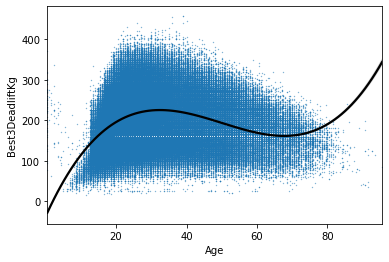

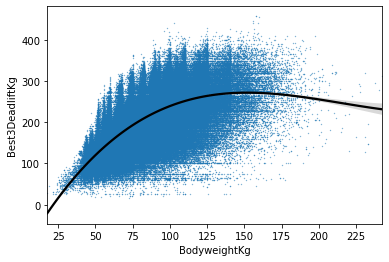

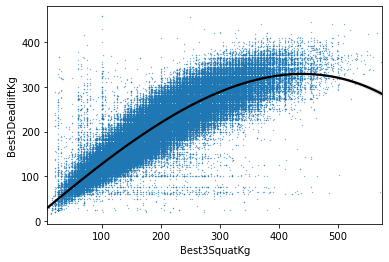

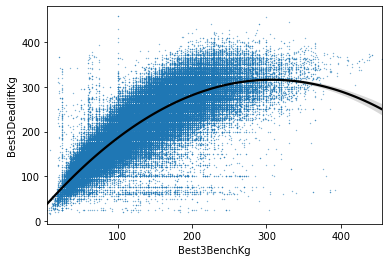

In [26]:
# Create scatter plots for each numerical value against the target

for cname in numerical:
    
    sns.regplot(x=X[cname], y=y, order=3, scatter_kws={'s': .1}, line_kws={'color': 'black'})
    
    plt.show()

## Categorical Features

In [27]:
# How many unique values does each categorical feature have?

for cname in categorical:
    print(cname + ": " + str(df[cname].nunique()))

Sex: 2
Equipment: 4
Division: 3318
Squat1Kg: 3
Squat2Kg: 3
Squat3Kg: 3
Bench1Kg: 3
Bench2Kg: 3
Bench3Kg: 3
Tested: 2
Country: 142
Federation: 196
Date: 4604
MeetCountry: 92
MeetState: 110


Most of these have very very high cardinality.\
One-Hot encode the ones with low cardinality.\
Target encode the ones with high cardinality.

In [28]:
pd.set_option('display.max_columns', 50)
X.head()

,Sex,Equipment,Age,Division,BodyweightKg,Squat1Kg,Squat2Kg,Squat3Kg,Best3SquatKg,Bench1Kg,Bench2Kg,Bench3Kg,Best3BenchKg,Tested,Country,Federation,Date,MeetCountry,MeetState
0,F,Wraps,29.0,F-OR,59.8,Success,Success,Success,105.0,Success,Success,Success,55.0,No,missing_value,GPC-AUS,2018-10-27,Australia,VIC
1,F,Wraps,29.0,F-OR,58.5,Success,Success,Success,120.0,Success,Success,Success,67.5,No,missing_value,GPC-AUS,2018-10-27,Australia,VIC
2,F,Wraps,23.0,F-OR,60.0,Fail,Fail,Success,105.0,Success,Success,Fail,72.5,No,missing_value,GPC-AUS,2018-10-27,Australia,VIC
3,F,Wraps,45.0,F-OR,104.0,Success,Success,Success,140.0,Success,Success,Success,80.0,No,missing_value,GPC-AUS,2018-10-27,Australia,VIC
4,F,Wraps,37.0,F-OR,74.0,Success,Success,Success,142.5,Success,Success,Success,82.5,No,missing_value,GPC-AUS,2018-10-27,Australia,VIC


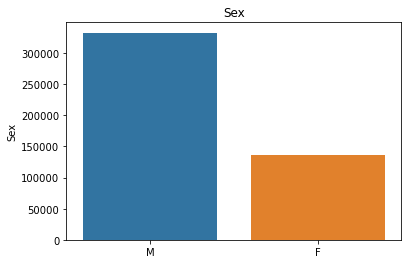

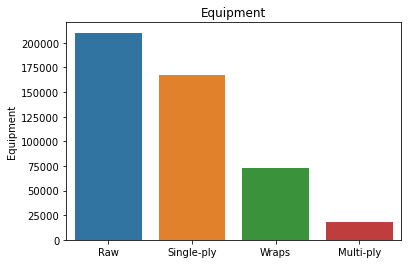

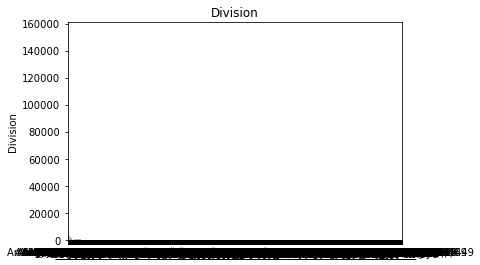

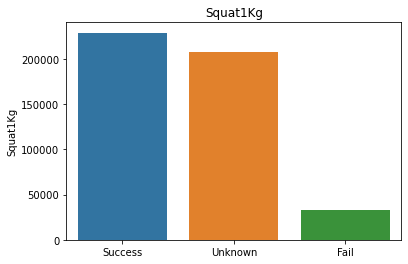

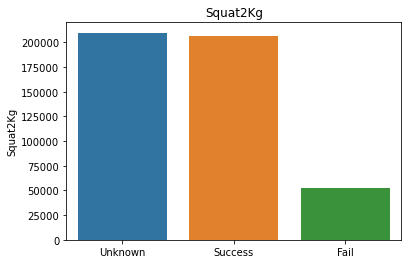

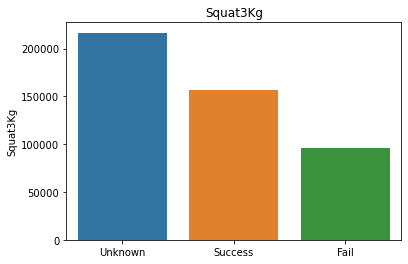

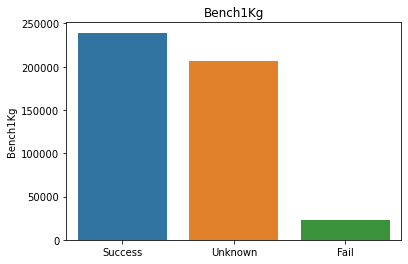

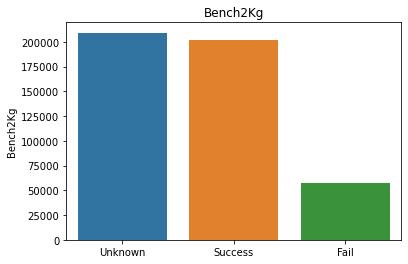

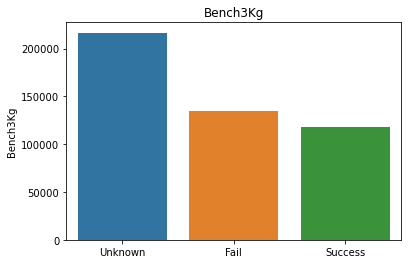

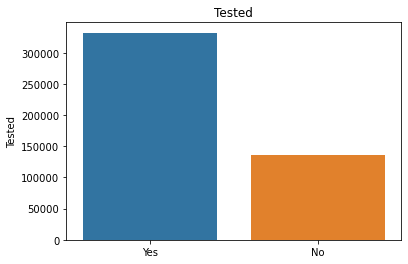

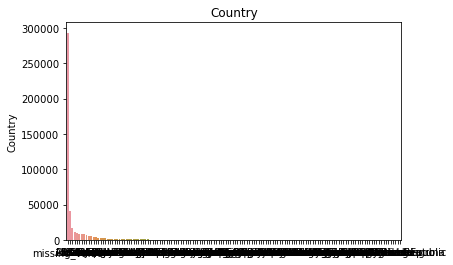

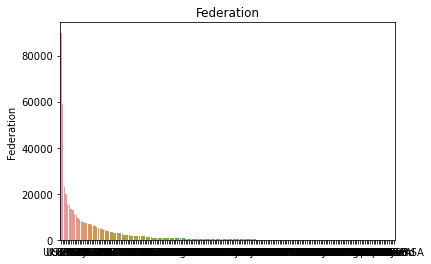

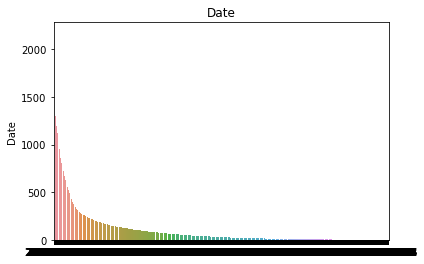

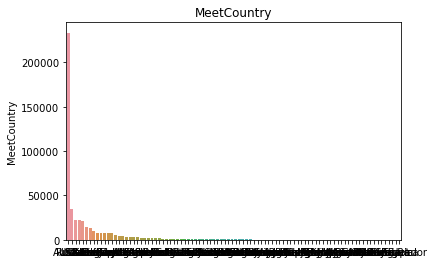

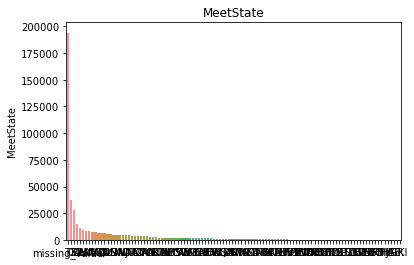

In [29]:
# Create barplots for each categorical feature to see their distributions

for cname in categorical:
    valueCounts = X[cname].value_counts()
    sns.barplot(valueCounts.index, valueCounts).set_title(cname)
    plt.show()

The barplots for Division, Country, Federation, MeetCountry, and MeetState look awful.\
Country, MeetState, and Division were imputed, so the highest bars are probably "missing_value".

In [30]:
X["Country"].value_counts().head()

missing_value    293432
USA               40432
Russia            17325
Ukraine           10914
Australia          9424
Name: Country, dtype: int64

In [31]:
X["MeetCountry"].value_counts().head()

USA          233570
Russia        34285
Australia     22437
Ukraine       22180
Czechia       21408
Name: MeetCountry, dtype: int64

In [32]:
X["MeetState"].value_counts().head()

missing_value    193992
TX                37109
CA                28061
FL                15278
OH                10674
Name: MeetState, dtype: int64

In [33]:
X["Division"].value_counts().head()

Open       153168
Juniors     26745
MR-O        24203
FR-O        14848
Boys        12438
Name: Division, dtype: int64

In [34]:
X["Federation"].value_counts().head()

USAPL        89935
USPA         58966
IPF          22757
FPR          19889
UkrainePF    15729
Name: Federation, dtype: int64

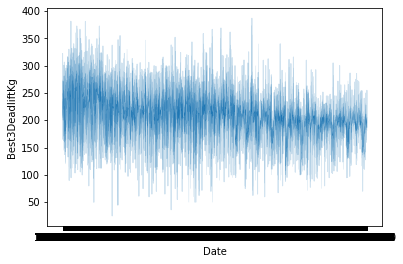

In [35]:
# Look at powerlifter's mean deadlifts over time

sns.lineplot(x=X["Date"], y=y, linewidth=.1, estimator='mean')

There is not a noticeable trend. I would think people's deadlifts increase over time because of advances in exercise and nutrition science. Maybe that's too naive because there are always experienced and inexperienced people going to these events.

In [36]:
# I don't want Date to be a factor in predicting deadlifts
# Also it doesn't seem to have any effect on Best Deadlift
# Drop Date
X = X.drop("Date", axis=1)
categorical.remove("Date")

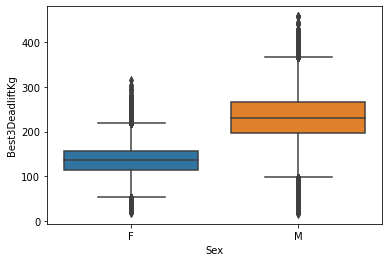

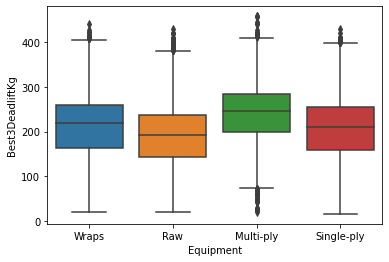

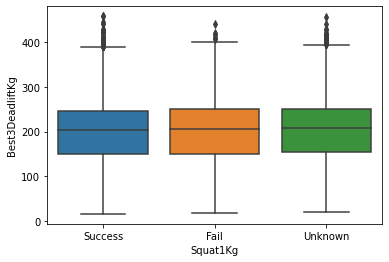

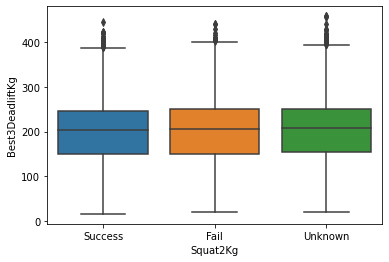

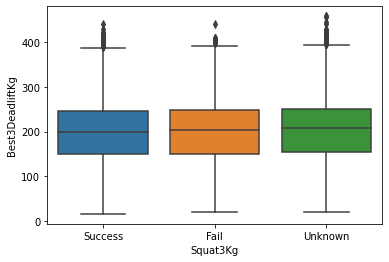

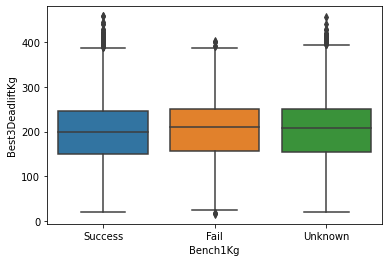

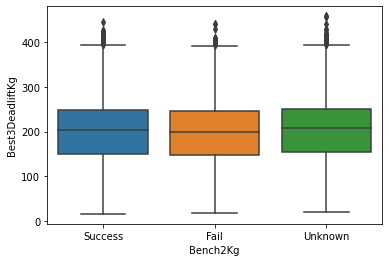

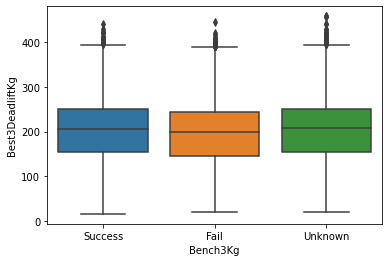

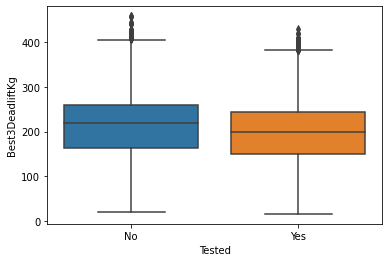

In [37]:
# See the boxplots for categorical features against Best3DeadliftKg
# Don't make boxplots for high cardinality features because their plots are hard to interpret

for cname in categorical:
    if X[cname].nunique() < 15:
        sns.boxplot(x=X[cname], y=y)
        plt.show()

Male deadlift median higher than female.\
Multi-ply deadlift median higher than other equipment.\
Non-tested deadlift higher than tested.\
The attempt features don't really mean much apparently.\
All makes sense.

In [38]:
# Look at high cardinality categorical features
# See the top 5 and bottom 5 categorical values by median

for cname in categorical:
    if X[cname].nunique() >= 15:
        print(df.groupby([cname])["Best3DeadliftKg"].agg(func='median').sort_values(ascending=False))
        print("\n") 

Division
Super Heavyweight    366.275
Elite Pro Open       360.000
Masters 45-50        353.800
1974                 350.000
MM-2 RA              350.000
                      ...   
8-9                   38.560
FR-M6                 35.000
Y 6-7                 30.000
7-8                   29.480
Paralympics           27.220
Name: Best3DeadliftKg, Length: 3318, dtype: float64


Country
Syria         295.0
Yugoslavia    287.5
Bulgaria      275.0
Swaziland     271.0
Luxembourg    270.0
              ...  
Niue          162.5
N.Ireland     150.0
Hong Kong     142.5
Nepal         140.0
Djibouti      120.0
Name: Best3DeadliftKg, Length: 142, dtype: float64


Federation
SCT            360.00
SPSS           340.00
WPC-Germany    305.00
WPC-Iceland    305.00
XPC            283.50
                ...  
NORCAL         162.50
IDFPA          160.00
MHSPLA         149.69
RAWU           145.15
THSWPA         124.74
Name: Best3DeadliftKg, Length: 196, dtype: float64


MeetCountry
Egypt         325.0

Division: Highest are Super Heavyweight and Elite Pro Open. Lowest are Ages 7-8 and Paralympics.\
Country: Highest lifters are from Syria, Yugoslavia, and Bulgaria. Lowest are from Hong Kong, Nepal, and Djibouti.\
Federation: Highest are SCT and SPSS. Lowest are RAWU and THSWPA. (no clue what any of those are).\
MeetCountry: Highest lifts are from Egypt. Lowest are from Kazakhstan and Costa Rica.\
MeetState: Highest lifts are from WB and GR. Lowest are from HG and DL. (no clue what any of those are).

# *Feature Engineering*

## Dealing with Categorical Values

In [39]:
X[categorical].head()

,Sex,Equipment,Division,Squat1Kg,Squat2Kg,Squat3Kg,Bench1Kg,Bench2Kg,Bench3Kg,Tested,Country,Federation,MeetCountry,MeetState
0,F,Wraps,F-OR,Success,Success,Success,Success,Success,Success,No,missing_value,GPC-AUS,Australia,VIC
1,F,Wraps,F-OR,Success,Success,Success,Success,Success,Success,No,missing_value,GPC-AUS,Australia,VIC
2,F,Wraps,F-OR,Fail,Fail,Success,Success,Success,Fail,No,missing_value,GPC-AUS,Australia,VIC
3,F,Wraps,F-OR,Success,Success,Success,Success,Success,Success,No,missing_value,GPC-AUS,Australia,VIC
4,F,Wraps,F-OR,Success,Success,Success,Success,Success,Success,No,missing_value,GPC-AUS,Australia,VIC


In [40]:
# One-Hot Encode columns with low cardinality

toOHEnc = ["Sex", "Equipment", "Tested", "Squat1Kg", "Squat2Kg", "Squat3Kg", "Bench1Kg", "Bench2Kg", "Bench3Kg"]

for cname in toOHEnc:
    X_one_hot = pd.get_dummies(X[cname], prefix=cname)
    X = pd.concat([X, X_one_hot], axis=1)
    X = X.drop(cname, axis=1)

In [41]:
# Target Encode columns with high cardinality

toTargetEnc = ["Division", "Country", "Federation", "MeetCountry", "MeetState"]
from category_encoders import TargetEncoder

# NOTE: Have to do this on a specific training split to avoid target leakage

## Creating New Features

In [42]:
X["Squat_Fail_Total"] = X["Squat1Kg_Fail"] + X["Squat2Kg_Fail"] + X["Squat3Kg_Fail"]
X["Squat_Success_Total"] = X["Squat1Kg_Success"] + X["Squat2Kg_Success"] + X["Squat3Kg_Success"]
X["Squat_Unknown_Total"] = X["Squat1Kg_Unknown"] + X["Squat2Kg_Unknown"] + X["Squat3Kg_Unknown"]

X["Bench_Fail_Total"] = X["Bench1Kg_Fail"] + X["Bench2Kg_Fail"] + X["Bench3Kg_Fail"]
X["Bench_Success_Total"] = X["Bench1Kg_Success"] + X["Bench2Kg_Success"] + X["Bench3Kg_Success"]
X["Bench_Unknown_Total"] = X["Bench1Kg_Unknown"] + X["Bench2Kg_Unknown"] + X["Bench3Kg_Unknown"]

In [43]:
X["Fail_Total"] = X["Squat_Fail_Total"]+X["Bench_Fail_Total"]
X["Success_Total"] = X["Squat_Success_Total"]+X["Bench_Success_Total"]
X["Unknown_Total"] = X["Squat_Unknown_Total"]+X["Bench_Unknown_Total"]

In [44]:
X["AgePerWeight"] = X["Age"]/X["BodyweightKg"]
X["BestSquatBench"] = X["Best3SquatKg"]*X["Best3BenchKg"]
X["AgeWeightBenchSquat"] = X["AgePerWeight"]*X["BestSquatBench"]

In [45]:
X.columns

Index(['Age', 'Division', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg',
       'Country', 'Federation', 'MeetCountry', 'MeetState', 'Sex_F', 'Sex_M',
       'Equipment_Multi-ply', 'Equipment_Raw', 'Equipment_Single-ply',
       'Equipment_Wraps', 'Tested_No', 'Tested_Yes', 'Squat1Kg_Fail',
       'Squat1Kg_Success', 'Squat1Kg_Unknown', 'Squat2Kg_Fail',
       'Squat2Kg_Success', 'Squat2Kg_Unknown', 'Squat3Kg_Fail',
       'Squat3Kg_Success', 'Squat3Kg_Unknown', 'Bench1Kg_Fail',
       'Bench1Kg_Success', 'Bench1Kg_Unknown', 'Bench2Kg_Fail',
       'Bench2Kg_Success', 'Bench2Kg_Unknown', 'Bench3Kg_Fail',
       'Bench3Kg_Success', 'Bench3Kg_Unknown', 'Squat_Fail_Total',
       'Squat_Success_Total', 'Squat_Unknown_Total', 'Bench_Fail_Total',
       'Bench_Success_Total', 'Bench_Unknown_Total', 'Fail_Total',
       'Success_Total', 'Unknown_Total', 'AgePerWeight', 'BestSquatBench',
       'AgeWeightBenchSquat'],
      dtype='object')

# *Data Cleaning Part 2*

## Normalization and Outliers

The numerical columns all looked relatively normal so I won't mess with log transforms or boxcox transforms.\
I didn't notice any huge outliers in numerical columns.

## Scaling

In [46]:
# Scale the numerical data for the models that require it (like KNearestNeighbors)
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

numerical.extend(["BestSquatBench", "AgeWeightBenchSquat"]) # Not extending AgePerWeight bc it'll always be <1

X[numerical] = scale.fit_transform(X[numerical])

# *Model Selection*

## Preprocessing and cross validation functions
NOTE: I could do things a lot simpler if I didn't have to worry about target leakage with the TargetEncoder. Right now, each validation split needs to be tailored to the values in the corresponding training split. I can't just pass in a preprocessed big X into a cross validation function which randomly splits the X, because it would contain target-leaked data. 

In [47]:
def get_preprocessed_cv_data(train_X, val_X, train_y, val_y):
    ###############################################################################################################
    # Data Cleaning
    # Filter rows based on these conditions
    for col in removeNANCols:
        train_X = train_X.loc[(train_X[col].isna() == False) & (train_X[col] > 0)]
        val_X = val_X.loc[(val_X[col].isna() == False) & (val_X[col] > 0)]

    # Filter the same rows out of y's
    
    train_y_toRemove = train_y.drop(train_X.index, axis=0)
    train_y = train_y.drop(train_y_toRemove.index, axis=0)
    
    val_y_toRemove = val_y.drop(val_X.index, axis=0)
    val_y = val_y.drop(val_y_toRemove.index, axis=0)
    
    # Reindex
    train_X.index = np.arange(train_X.shape[0])
    val_X.index = np.arange(train_X.shape[0], train_X.shape[0]+val_X.shape[0])
    
    train_y.index = train_X.index
    val_y.index = val_X.index
    
    # Make these rows easier to work with
    for col in attemptCols:
        train_X[col] = train_X[col].apply(lambda x: attemptTransformer(x))
        val_X[col] = val_X[col].apply(lambda x: attemptTransformer(x))
    
    # Imputation
    train_X["Tested"] = train_X["Tested"].fillna("No")
    val_X["Tested"] = val_X["Tested"].fillna("No")
    
    simpImputer = SimpleImputer(strategy="constant")
    train_X[simpImputeCols] = simpImputer.fit_transform(train_X[simpImputeCols])
    val_X[simpImputeCols] = simpImputer.transform(val_X[simpImputeCols])
        
    ###############################################################################################################
    # One-Hot Encode the columns with low cardinality
    for cname in toOHEnc:
        train_X_one_hot = pd.get_dummies(train_X[cname], prefix=cname)
        train_X = pd.concat([train_X, train_X_one_hot], axis=1)
        train_X = train_X.drop(cname, axis=1)
        
        val_X_one_hot = pd.get_dummies(val_X[cname], prefix=cname)
        val_X = pd.concat([val_X, val_X_one_hot], axis=1)
        val_X = val_X.drop(cname, axis=1)
    
    # Sometimes there isn't a success or fail or unknown value present in the split, so the column is never made
    # These columns are necessary for the later feature engineering
    for col in ["Squat1Kg_Fail", "Squat1Kg_Success", "Squat1Kg_Unknown", "Bench1Kg_Fail", "Bench1Kg_Success", "Bench1Kg_Unknown",
               "Squat2Kg_Fail", "Squat2Kg_Success", "Squat2Kg_Unknown", "Bench2Kg_Fail", "Bench2Kg_Success", "Bench2Kg_Unknown",
               "Squat3Kg_Fail", "Squat3Kg_Success", "Squat3Kg_Unknown", "Bench3Kg_Fail", "Bench3Kg_Success", "Bench3Kg_Unknown"]:
        
        if col not in train_X.columns.tolist():
            train_X[col] = 0
        if col not in val_X.columns.tolist():
            val_X[col] = 0
            
    ###############################################################################################################
    # Target Encode the columns with high cardinality
        
    enc = TargetEncoder(cols=toTargetEnc, handle_missing="value", handle_unknown="value")
    train_X = enc.fit_transform(train_X, train_y)
    val_X = enc.transform(val_X)
    
    ###############################################################################################################
    # Feature Engineering
    
    train_X["Squat_Fail_Total"] = train_X["Squat1Kg_Fail"] + train_X["Squat2Kg_Fail"] + train_X["Squat3Kg_Fail"]
    train_X["Squat_Success_Total"] = train_X["Squat1Kg_Success"] + train_X["Squat2Kg_Success"] + train_X["Squat3Kg_Success"]
    train_X["Squat_Unknown_Total"] = train_X["Squat1Kg_Unknown"] + train_X["Squat2Kg_Unknown"] + train_X["Squat3Kg_Unknown"]

    train_X["Bench_Fail_Total"] = train_X["Bench1Kg_Fail"] + train_X["Bench2Kg_Fail"] + train_X["Bench3Kg_Fail"]
    train_X["Bench_Success_Total"] = train_X["Bench1Kg_Success"] + train_X["Bench2Kg_Success"] + train_X["Bench3Kg_Success"]
    train_X["Bench_Unknown_Total"] = train_X["Bench1Kg_Unknown"] + train_X["Bench2Kg_Unknown"] + train_X["Bench3Kg_Unknown"]

    train_X["Fail_Total"] = train_X["Squat_Fail_Total"]+train_X["Bench_Fail_Total"]
    train_X["Success_Total"] = train_X["Squat_Success_Total"]+train_X["Bench_Success_Total"]
    train_X["Unknown_Total"] = train_X["Squat_Unknown_Total"]+train_X["Bench_Unknown_Total"]

    train_X["AgePerWeight"] = train_X["Age"]/train_X["BodyweightKg"]
    train_X["BestSquatBench"] = train_X["Best3SquatKg"]*train_X["Best3BenchKg"]
    train_X["AgeWeightBenchSquat"] = train_X["AgePerWeight"]*train_X["BestSquatBench"]
    
    
    val_X["Squat_Fail_Total"] = val_X["Squat1Kg_Fail"] + val_X["Squat2Kg_Fail"] + val_X["Squat3Kg_Fail"]
    val_X["Squat_Success_Total"] = val_X["Squat1Kg_Success"] + val_X["Squat2Kg_Success"] + val_X["Squat3Kg_Success"]
    val_X["Squat_Unknown_Total"] = val_X["Squat1Kg_Unknown"] + val_X["Squat2Kg_Unknown"] + val_X["Squat3Kg_Unknown"]

    val_X["Bench_Fail_Total"] = val_X["Bench1Kg_Fail"] + val_X["Bench2Kg_Fail"] + val_X["Bench3Kg_Fail"]
    val_X["Bench_Success_Total"] = val_X["Bench1Kg_Success"] + val_X["Bench2Kg_Success"] + val_X["Bench3Kg_Success"]
    val_X["Bench_Unknown_Total"] = val_X["Bench1Kg_Unknown"] + val_X["Bench2Kg_Unknown"] + val_X["Bench3Kg_Unknown"]

    val_X["Fail_Total"] = val_X["Squat_Fail_Total"]+val_X["Bench_Fail_Total"]
    val_X["Success_Total"] = val_X["Squat_Success_Total"]+val_X["Bench_Success_Total"]
    val_X["Unknown_Total"] = val_X["Squat_Unknown_Total"]+val_X["Bench_Unknown_Total"]

    val_X["AgePerWeight"] = val_X["Age"]/val_X["BodyweightKg"]
    val_X["BestSquatBench"] = val_X["Best3SquatKg"]*val_X["Best3BenchKg"]
    val_X["AgeWeightBenchSquat"] = val_X["AgePerWeight"]*val_X["BestSquatBench"]
    
    return train_X, val_X, train_y, val_y

In [48]:
# Create 5 Cross Validation folds and keep track of the preprocessed train/test sets they create
# Can speed up each following cell because I don't have to run the folds every time
# Just have to fit to each of the 5 sets of data and get the average score at the end
# Can make a function that takes a model and a bunch of training/validation sets and returns the average score

# This multiplies the RAM used x5 but I shouldn't go over 16GB

from sklearn.model_selection import KFold

# I'm choosing to score with MAE because it's more interpretable
from sklearn.metrics import mean_absolute_error

def get_folds(X, y):

    folds = []
    kf = KFold(n_splits=5)
    for train_index, val_index in kf.split(X):
        train_X, val_X, train_y, val_y = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        train_X, val_X, train_y, val_y = get_preprocessed_cv_data(train_X, val_X, train_y, val_y)
        folds.append((train_X, val_X, train_y, val_y))
        
    for fold in folds:
        train_X, val_X, train_y, val_y = fold[0], fold[1], fold[2], fold[3]
        print("Shapes:", train_X.shape, train_y.shape, val_X.shape, val_y.shape)
        
    return folds


def get_fold_scores(folds, model):
    
    totalError = 0
    for fold in folds:
        train_X, val_X, train_y, val_y = fold[0], fold[1], fold[2], fold[3]
        model.fit(train_X, train_y)
        predictions = model.predict(val_X)
        totalError += mean_absolute_error(val_y, predictions)
    
    return totalError/5

## Model Training

IMPORTANT: Because I have so much data, it takes absolutely forever to train the more complicated models with KFold and GridSearch running simultaneously. I'm going to forgo using GridSearch or RandomSearch to tune hyperparameters now. I'll see which model works best from its default hyperparameters based off of KFold, then tune hyperparameters later.

In [49]:
# Get a fresh X and y
df = pd.read_csv(fname)

# Drop Useless Columns
df = df.drop(["TotalKg", "Place", "Wilks", "Glossbrenner", "IPFPoints", "McCulloch", "Squat4Kg",
            "Bench4Kg", "Deadlift1Kg", "Deadlift2Kg", "Deadlift3Kg", "Deadlift4Kg", "AgeClass",
              "WeightClassKg", "MeetName", "Event", "Name", "Date"], axis=1)

# Set up Best3DeadliftKg to have real positive values
df = df.loc[(df["Best3DeadliftKg"].isna() == False) & (df["Best3DeadliftKg"] > 0)]

# Reindex
df.index = np.arange(df.shape[0])

# Remove Best3DeadliftKg from removeNANCols because I just removed its NANs
if "Best3DeadliftKg" in removeNANCols:
        removeNANCols.remove("Best3DeadliftKg")

X = df.drop("Best3DeadliftKg", axis=1)
y = df["Best3DeadliftKg"]

# Shuffle the data because I think it's in some kind of order
# Also makes my KFold basically a StratifiedKFold
from sklearn.utils import shuffle
X, y = shuffle(X, y)

In [50]:
# How much data do I start off with before preprocessing?

print(X.shape, y.shape)

(1081152, 18) (1081152,)


In [51]:
# Get the 5 CV folds to test on each model

folds = get_folds(X, y)

Shapes: (375030, 47) (375030,) (93813, 47) (93813,)
Shapes: (374851, 47) (374851,) (93992, 47) (93992,)
Shapes: (375491, 47) (375491,) (93352, 47) (93352,)
Shapes: (374996, 47) (374996,) (93847, 47) (93847,)
Shapes: (375004, 47) (375004,) (93839, 47) (93839,)


In [52]:
# Support Vector Machines, K Nearest Neighbors, and Ridge Regression rely on scaled data

scaledFolds = folds.copy()

for fold in scaledFolds:
    train_X, val_X, train_y, val_y = fold[0], fold[1], fold[2], fold[3]
    scale = StandardScaler()
    train_X[numerical] = scale.fit_transform(train_X[numerical])
    val_X[numerical] = scale.transform(val_X[numerical])

In [53]:
# Model: Linear Regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# print(get_fold_scores(folds, model))

# Previous Output:
# 15.77874015086079

In [54]:
# Model: Ridge Regression
from sklearn.linear_model import Ridge

model = Ridge()

# print(get_fold_scores(scaledFolds, model))

# Previous Output:
# 15.778774089924635

In [55]:
# Model: Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor()

# print(get_fold_scores(folds, model))

# Previous Output:
# 19.417925633468293

In [56]:
# Model: K Nearest Neighbors Regressor
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()

# print(get_fold_scores(scaledFolds, model))

# Previous Output:
# 19.946031144268616

In [57]:
# Model: XGBoost Regressor
from xgboost import XGBRegressor

model = XGBRegressor()

# print(get_fold_scores(folds, model))

# Previous Output:
# 14.679437128510765

In [58]:
# Model: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

# print(get_fold_scores(folds, model))

# Previous Output:
# 14.05798364898988

In [59]:
# Model: Support Vector Regressor
from sklearn.svm import LinearSVR

# Not using base SVR() because of the quadratic fit time with respect to observations

model = LinearSVR()

# print(get_fold_scores(scaledFolds, model))

# Previous Output:
# 21.95390

## Results

Which model to choose? (based on Mean Absolute Error and default hyperparameters)
* **Linear Regression**: 15.77874
* **Ridge Regression**: 15.77877
* **Decision Tree**: 19.41793
* **K Nearest Neighbors**: 19.94603
* **XGBoost**: 14.67944
* **Random Forest**: *14.05798*
* **Linear Support Vector Machine**: 21.95390

Even though the Random Forest Classifier performed the best, it took like an hour to run its cell. The next best options are XGBoost and Ridge/Linear Regression. The latter trained lightning quick but the former has just a bit better score, so I'm going to go with it. Surprisingly, XGBoost didn't take nearly as long to train as the RandomForestClassifier.

Also, the differences in MAE across all models is miniscule. It's a difference of a few kilograms of weight.

## Hyperparameter Optimization

In [60]:
# Find the best hyperparamters for the chosen model using RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit

# Using RandomizedSearchCV instead of GridSearchCV because it does fewer iterations through parameter space
# The cost is it might not find the absolute best hyperparameters
from sklearn.model_selection import RandomizedSearchCV

def find_best_hyperparameters():

    # Define the chosen model
    model = XGBRegressor()

    # Value ideas from: https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
    # and https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/
    paramfield = {'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
                  'n_estimators': range(50, 400, 50),
                  "max_depth": range(1, 11, 2),
                 }

    totalScore = 0
    bestScore = 0
    bestParams = {}

    # Use 5 random train/test splits instead of KFolds
    for _ in range(5):
        # Create train/test splits and preprocess using previously defined function
        train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=.8, test_size=.2)
        train_X, val_X, train_y, val_y = get_preprocessed_cv_data(train_X, val_X, train_y, val_y)

        train_length = train_X.shape[0]
        val_length = val_X.shape[0]

        new_X = pd.concat([train_X, val_X], axis=0)
        new_y = pd.concat([train_y, val_y], axis=0)


        # Want to find the best hyperparameters for this specific train/test split
        # Create a list where train data indices are -1 and validation data indices are 0
        # Source: https://stackoverflow.com/questions/31948879/using-explicit-predefined-validation-set-for-grid-search-with-sklearn
        split_index = [-1 if i<=train_length else 0 for i in range(train_length+val_length)]

        ps = PredefinedSplit(test_fold = split_index)

        # Scoring metric is from the dataset description
        # Tries out all permutations of parameters in paramField on this split
        clf = RandomizedSearchCV(model, paramfield, scoring="neg_mean_absolute_error", cv=ps, n_iter=10)

        # Fit the classifier using the preprocessed X and y
        # It will know what the validation set is bc the PredefinedSplit
        clf.fit(new_X, new_y)

        # Get the best score from this split coming from the best params
        score = clf.best_score_

        # Add to the totalScore to later return the average score
        totalScore += score

        # If this is the best split so far, keep track of the found hyperparameters
        if score >= bestScore:
            bestParams = clf.best_params_

        print(score, clf.best_params_)

# find_best_hyperparameters()

# Previous Output:
# -14.647675587224361 {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2}
# -14.32331298119558 {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.2}
# -14.34693246644678 {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.2}
# -14.273737167689513 {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1}
# -14.278972928620703 {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.2}

In [61]:
# Fit the model on another random train/test split using tuned hyperparameters

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=.8, test_size=.2)
train_X, val_X, train_y, val_y = get_preprocessed_cv_data(train_X, val_X, train_y, val_y)

# From RandomizedSearchCV: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1}
model = XGBRegressor(n_estimators = 300, max_depth = 9, learning_rate = 0.1)
model.fit(train_X, train_y)
predictions = model.predict(val_X)
        
print(mean_absolute_error(val_y, predictions))

14.33037914178597


# *Feature Selection*
Why?
- Prevents overfitting on training and validation data
- Train and do inference faster with fewer features

In [62]:
# Use L1 Regularization to see the most important features
# The less important coefficients will be regularized to 0
# Make alpha higher to remove more features

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Lasso Relies on scaled data
scaled_train_X = train_X.copy()
scaled_train_X[numerical] = StandardScaler().fit_transform(train_X[numerical])

lasso = Lasso(alpha=1).fit(scaled_train_X, train_y)

# Select the nonzero coefficients
selector = SelectFromModel(lasso, prefit=True)

train_X_new = selector.transform(scaled_train_X)

In [63]:
# Create a list of which features were selected

selected_df = pd.DataFrame(selector.inverse_transform(train_X_new),
                          index=np.arange(train_X_new.shape[0]),
                          columns=train_X.columns.tolist())

selected_features = selected_df.columns[selected_df.sum() != 0]

selected_features

Index(['Division', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Country',
       'Federation', 'MeetState', 'Sex_F', 'Equipment_Raw',
       'Equipment_Single-ply'],
      dtype='object')

In [64]:
# See which features should be removed according to this method

for col in train_X.columns.tolist():
    if col not in selected_features:
        print(col)

Age
MeetCountry
Sex_M
Equipment_Multi-ply
Equipment_Wraps
Tested_No
Tested_Yes
Squat1Kg_Fail
Squat1Kg_Success
Squat1Kg_Unknown
Squat2Kg_Fail
Squat2Kg_Success
Squat2Kg_Unknown
Squat3Kg_Fail
Squat3Kg_Success
Squat3Kg_Unknown
Bench1Kg_Fail
Bench1Kg_Success
Bench1Kg_Unknown
Bench2Kg_Fail
Bench2Kg_Success
Bench2Kg_Unknown
Bench3Kg_Fail
Bench3Kg_Success
Bench3Kg_Unknown
Squat_Fail_Total
Squat_Success_Total
Squat_Unknown_Total
Bench_Fail_Total
Bench_Success_Total
Bench_Unknown_Total
Fail_Total
Success_Total
Unknown_Total
AgePerWeight
BestSquatBench
AgeWeightBenchSquat


I guess all that feature engineering with the fails and successes of lifts were useless.\
Age not being useful very much surprises me. It's probably because I normalized it with BoxCox and then scaled it.\
Also, how is being tested not useful? People taking PEDs should be able to lift more.\
None of the interaction features I made were useful.

In [65]:
# Different aproach to see feature importance
# Permutation importance

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model).fit(val_X, val_y)
eli5.show_weights(perm, top=100, feature_names = val_X.columns.tolist())

Weight,Feature
0.5428 ± 0.0056,BestSquatBench
0.4062 ± 0.0032,Best3SquatKg
0.1028 ± 0.0029,Best3BenchKg
0.0851 ± 0.0014,BodyweightKg
0.0372 ± 0.0006,Sex_F
0.0178 ± 0.0005,AgeWeightBenchSquat
0.0111 ± 0.0005,Age
0.0089 ± 0.0004,Equipment_Raw
0.0061 ± 0.0003,Division
0.0060 ± 0.0003,AgePerWeight


Permutation importance tells a different story. Here, the interaction feature of BestSquatBench was a very powerful predictor.\
However, its inclusion is probably pointless if I already have BestSquat and BestBench in the feature set.\
Age was also important, along with its interaction features.\
Maybe I should reduce alpha in the L1 regularization to see how many more features it says are important.\
Maybe different features become important in a linear model like Lasso than in XG Boost?

In [66]:
# Test the model's MAE score on only the selected features from L1 Regularization

model_selected = XGBRegressor(n_estimators = 300, max_depth = 9, learning_rate = 0.1)

train_X_selected = train_X[selected_features]
val_X_selected = val_X[selected_features]

model_selected.fit(train_X_selected, train_y)
predictions = model_selected.predict(val_X_selected)
        
print(mean_absolute_error(val_y, predictions))

14.658602003603022


Okay, slightly worse score, but like 40 features were removed, so I think that's great.\
I'm going to continue further analysis with all the features, just to see the whole picture.

## Feature Selection Conclusion

If I were to use this model in the real world, not needing all those features regarding fails and successes on 1 rep max Bench and Squat attempts would be amazing. Those features and the ones I engineered from them really increase the number of features I had, while not being useful at all. Also some features are redundant, like Sex_M, so that wouldn't even be needed.

Furthermore, I think the scaling of Age hurt my ability to interpret its importance with L1 Regularization in Lasso Regression. I don't think there's a way around that because Lasso Regression needs scaled data.

# *Machine Learning Explainability*
#### Making sense of the model's predictions

## Partial Dependence Plots

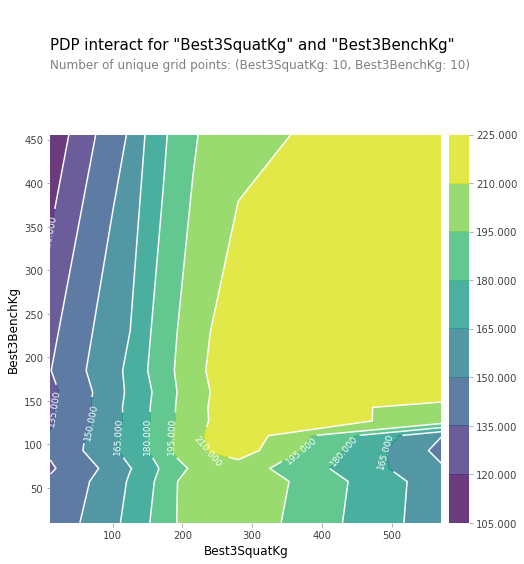

In [67]:
# See how exactly Squat and Bench affect predictions

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

features_to_plot = ['Best3SquatKg', 'Best3BenchKg']
inter1  =  pdp.pdp_interact(model=model, dataset=val_X, model_features=val_X.columns.tolist(), features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

It looks like there's a sweet spot around 300kg on Squat and 200kg Bench where Deadlift Kg is the highest. Maybe those with really high Bench or really high Squat are specialists.

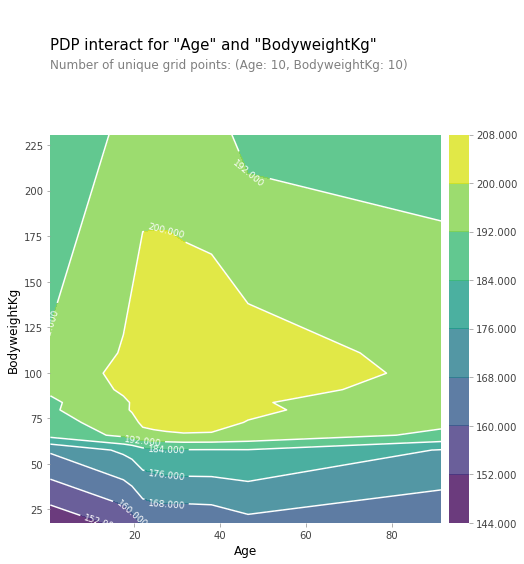

In [68]:
# See how exactly Age and Annual Premiumn affect predictions

from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

features_to_plot = ['Age', 'BodyweightKg']
inter1  =  pdp.pdp_interact(model=model, dataset=val_X, model_features=val_X.columns.tolist(), features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

It looks like there's also a sweet spot around age 30 and a bodyweight of around 125kg.

## SHAP Value Plots

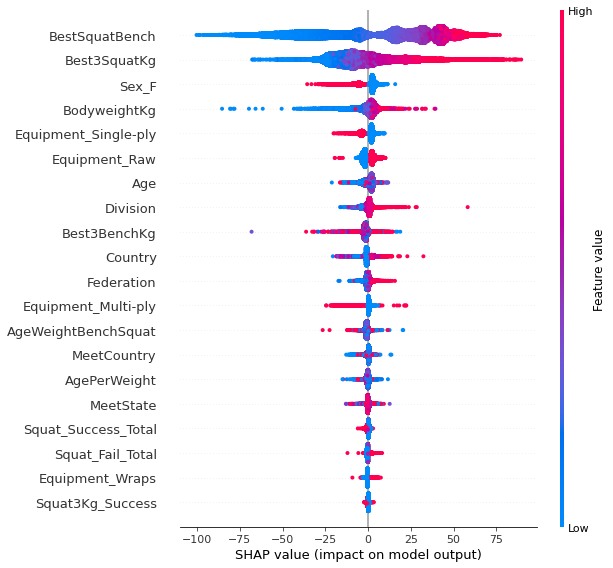

In [69]:
# Another way to see relationships between variables
# SHAP values and SHAP summary plots

import shap

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(val_X)

shap.summary_plot(shap_values, val_X)

Clear indicators of a high 1 Rep Max Deadlift:
* High 1RM Squat
* Higher bodyweight
* Male
* In a Federation/Division that historically has high deadlifts
* Born in a country whose competitors historically have high deadlifts

Not-so-clear indicators of a high 1RM Deadlift:
* For some reason, lifting raw (without equipment) leads to a higher deadlift. I would think using wraps would help more. Maybe the original data is biased in some way.
* Bench doesn't help as much as I previously thought. For some people, they had a high bench but very low squat. I mean it makes sense because it's not a lower body movement, but it's still a staple strength movement.
* I would think a lower age would help, but maybe not.

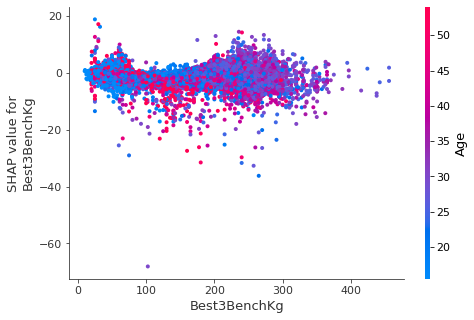

In [70]:
# Partial Dependence Plot, but enhanced with SHAP values
# Check out Age and Bench

shap.dependence_plot("Best3BenchKg", shap_values, val_X, interaction_index="Age")

I don't see a clear pattern here between Bench and Age with the SHAP values from Best3DeadliftKg. It seems that people in the middle range of ages have a higher bench, but that doesn't correlate very much with the SHAP values. This is surprising because of the graph I made earlier that showed quite a large correlation between highest bench and highest deadlift.

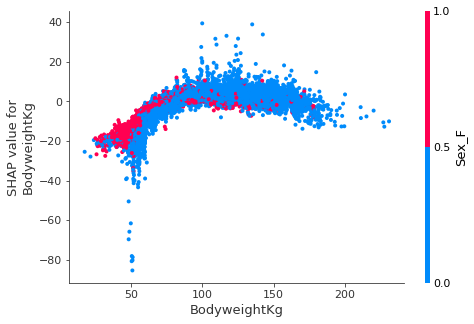

In [71]:
# Partial Dependence Plot, but enhanced with SHAP values
# Check out the interaction between Squat and Sex_F

shap.dependence_plot("BodyweightKg", shap_values, val_X, interaction_index="Sex_F")

Clearly, there are more males than females in this dataset. Even though most women are of lower body weight, there are some around 75kg bodyweight who have a higher deadlift compared to men of the same bodyweight. Women above 100kg bodyweight have comparatively lower deadlifts than men of the same bodyweight.

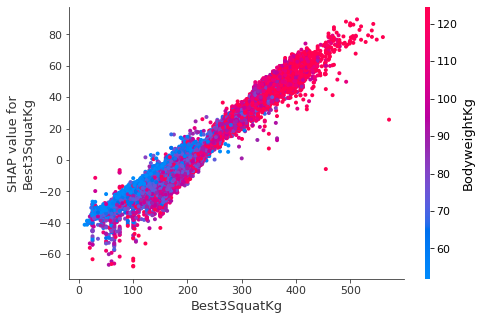

In [72]:
# Partial Dependence Plot, but enhanced with SHAP values
# Check out the interaction between Squat and Sex_F

shap.dependence_plot("Best3SquatKg", shap_values, val_X, interaction_index="BodyweightKg")

Really only the heaviest people are able to squat 400kg+. And this correlates heavily with a higher deadlift because they're both lower body movements.